# The Very Basics of Musical Instruments Classification using Machine Learning
## Short-Time Fourier Transform (STFT) and Convolutional Neural Networks (CNN) 

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



## Imports

In [1]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Data
import pandas as pd

# Visualization
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model


# Random Seed
from tensorflow import set_random_seed
from numpy.random import seed
seed(0)
set_random_seed(0)

# Audio
import librosa.display, librosa
import IPython.display as ipd

# Configurations
path='./audio/london_phill_dataset_multi/'

config = tf.ConfigProto(log_device_placement=True)
session = tf.Session(config=config)
set_session(session)
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5883724136188198700
]


## Configurations for Google Colab

In [2]:
# Only for Google Colab
try:
    import google.colab
    !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
    !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
    path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    !pip install tensorboardcolab
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    if "GPU:0" in tf.test.gpu_device_name():
        config.device_count = {'GPU': 0}
    session = tf.Session(config=config)
    set_session(session)

except Exception as e:
    print("Not inside Google Colab: %s. Using standard configurations." % (e))
 

Not inside Google Colab: No module named 'google.colab'


## Parameters

In [3]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames


# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing


## Aux Functions

In [4]:
# Function to Display a Website
display(HTML("<style>.container { width:100% !important; }</style>"))
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Find Audio Files, Generate Labels and Get Duration

In [5]:
#Find Audio Files
files = []
labels =[]
duration = []
classes=['flute','sax','oboe', 'cello','trumpet','viola']
for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.mp3')):
        files.append(os.path.join(root, filename))
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*'+name+'*'):
                labels.append(name)
                break
        else:
            labels.append('other')
        print ("Get %d = %s"%(i+1, filename))
        try:
            y, sr = librosa.load(files[i], sr=fs)
            if len(y) < 2:
                print("Error loading %s" % filename)
                continue
            #y/=y.max() #Normalize
            yt, index = librosa.effects.trim(y,top_db=60) #Trim
            duration.append(librosa.get_duration(yt, sr=fs))
        except Exception as e:
            print("Error loading %s. Error: %s" % (filename,e))


print("found %d audio files in %s"%(len(files),path))

Get 1 of 1 = viola_Gs4_025_pianissimo_arco-normal.mp3
Get 2 of 2 = viola_A4_1_fortissimo_snap-pizz.mp3
Get 3 of 3 = viola_A3_1_piano_pizz-normal.mp3
Get 4 of 4 = viola_Gs4_05_pianissimo_arco-normal.mp3
Get 5 of 5 = viola_Gs3_025_fortissimo_arco-normal.mp3
Get 6 of 6 = viola_A3_1_piano_arco-normal.mp3
Get 7 of 7 = viola_A4_025_piano_arco-normal.mp3
Get 8 of 8 = viola_A3_025_mezzo-piano_arco-normal.mp3
Get 9 of 9 = viola_Gs4_15_mezzo-piano_arco-normal.mp3
Get 10 of 10 = viola_A5_1_fortissimo_arco-normal.mp3
Get 11 of 11 = viola_Gs4_1_mezzo-piano_arco-normal.mp3
Get 12 of 12 = viola_Gs5_05_fortissimo_arco-normal.mp3
Get 13 of 13 = viola_Gs5_1_fortissimo_snap-pizz.mp3
Get 14 of 14 = viola_Gs5_025_mezzo-piano_arco-normal.mp3
Get 15 of 15 = viola_A3_1_fortissimo_arco-normal.mp3
Get 16 of 16 = viola_A4_15_fortissimo_arco-normal.mp3
Get 17 of 17 = viola_A4_05_forte_arco-normal.mp3
Get 18 of 18 = viola_A5_1_pianissimo_arco-normal.mp3
Get 19 of 19 = viola_A4_1_piano_arco-normal.mp3
Get 20 of 20 

Get 57 of 157 = saxophone_A5_15_forte_normal.mp3
Get 58 of 158 = saxophone_Gs4_05_forte_normal.mp3
Get 59 of 159 = saxophone_Gs5_05_piano_normal.mp3
Get 60 of 160 = saxophone_Gs5_1_piano_normal.mp3
Get 61 of 161 = saxophone_A5_05_piano_normal.mp3
Get 62 of 162 = saxophone_A3_15_pianissimo_normal.mp3
Get 63 of 163 = saxophone_A5_15_fortissimo_normal.mp3
Get 64 of 164 = saxophone_Gs5_1_pianissimo_normal.mp3
Get 65 of 165 = saxophone_Gs4_15_pianissimo_normal.mp3
Get 66 of 166 = saxophone_Ds4_05_pianissimo_subtone.mp3
Get 67 of 167 = saxophone_A5_05_pianissimo_normal.mp3
Get 68 of 168 = saxophone_Ds4_025_pianissimo_normal.mp3
Get 69 of 169 = saxophone_A3_05_fortissimo_normal.mp3
Get 70 of 170 = saxophone_Gs4_15_fortissimo_normal.mp3
Get 71 of 171 = saxophone_A4_05_piano_normal.mp3
Get 72 of 172 = saxophone_A4_15_piano_normal.mp3
Get 73 of 173 = saxophone_Ds4_05_mezzo-forte_normal.mp3
Get 74 of 174 = saxophone_A3_025_forte_normal.mp3
Get 75 of 175 = saxophone_Gs3_05_forte_normal.mp3
Get 76 

Get 26 of 326 = trumpet_Cs4_15_pianissimo_normal.mp3
Get 27 of 327 = trumpet_D4_05_pianissimo_normal.mp3
Get 28 of 328 = trumpet_E6_025_forte_normal.mp3
Get 29 of 329 = trumpet_Ds6_025_forte_normal.mp3
Get 30 of 330 = trumpet_E3_025_pianissimo_normal.mp3
Get 31 of 331 = trumpet_B5_025_forte_normal.mp3
Get 32 of 332 = trumpet_C6_025_forte_normal.mp3
Get 33 of 333 = trumpet_D4_05_forte_normal.mp3
Get 34 of 334 = trumpet_As4_025_forte_normal.mp3
Get 35 of 335 = trumpet_F4_025_pianissimo_normal.mp3
Get 36 of 336 = trumpet_A3_15_pianissimo_normal.mp3
Get 37 of 337 = trumpet_Gs3_1_pianissimo_normal.mp3
Get 38 of 338 = trumpet_Gs3_05_pianissimo_normal.mp3
Get 39 of 339 = trumpet_F4_05_pianissimo_normal.mp3
Get 40 of 340 = trumpet_D4_025_forte_normal.mp3
Get 41 of 341 = trumpet_Cs4_1_pianissimo_normal.mp3
Get 42 of 342 = trumpet_C4_025_forte_normal.mp3
Get 43 of 343 = trumpet_C4_1_pianissimo_normal.mp3
Get 44 of 344 = trumpet_A4_05_forte_normal.mp3
Get 45 of 345 = trumpet_G3_15_pianissimo_norm

Get 94 of 494 = flute_A5_05_mezzo-forte_normal.mp3
Get 95 of 495 = flute_A6_05_mezzo-forte_normal.mp3
Get 96 of 496 = flute_Gs5_05_mezzo-piano_normal.mp3
Get 97 of 497 = flute_Gs5_1_forte_normal.mp3
Get 98 of 498 = flute_A4_05_piano_normal.mp3
Get 99 of 499 = flute_Gs5_025_forte_normal.mp3
Get 100 of 500 = flute_Gs4_15_pianissimo_normal.mp3
Get 1 of 501 = cello_Gs5_025_mezzo-piano_arco-normal.mp3
Get 2 of 502 = cello_Gs5_15_forte_arco-normal.mp3
Get 3 of 503 = cello_A2_05_pianissimo_arco-normal.mp3
Get 4 of 504 = cello_Gs4_05_pianissimo_arco-normal.mp3
Get 5 of 505 = cello_A2_1_fortissimo_arco-normal.mp3
Get 6 of 506 = cello_A3_025_pianissimo_arco-normal.mp3
Get 7 of 507 = cello_Gs5_05_forte_arco-normal.mp3
Get 8 of 508 = cello_A3_1_mezzo-piano_non-vibrato.mp3
Get 9 of 509 = cello_A2_1_forte_arco-normal.mp3
Get 10 of 510 = cello_Gs4_15_pianissimo_arco-normal.mp3
Get 11 of 511 = cello_Gs4_025_forte_arco-normal.mp3
Get 12 of 512 = cello_A3_05_fortissimo_arco-normal.mp3
Get 13 of 513 = ce

In [6]:
print("Max. Duration:", max(duration))
print("Min. Duration:", min(duration))
print("Average Duration:", np.mean(duration))

Max. Duration: 3.2536961451247164
Min. Duration: 0.3657142857142857
Average Duration: 1.082833560090703


## Trim Silence and Recalculate Duration

In [7]:
# Load audio files, trim silence and calculate duration
duration = []
for i,f in enumerate(files):
    print ("Get %d  %s"%(i+1, f))
    try:
        y, sr = librosa.load(f, sr=fs)
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        #y/=y.max() #Normalize
        yt, index = librosa.effects.trim(y,top_db=60) #Trim
        duration.append(librosa.get_duration(yt, sr=fs))
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d Durations"%len(duration))

Get 1 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_025_pianissimo_arco-normal.mp3
Get 2 = ./audio/london_phill_dataset_multi/viola/viola_A4_1_fortissimo_snap-pizz.mp3
Get 3 = ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_pizz-normal.mp3
Get 4 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_05_pianissimo_arco-normal.mp3
Get 5 = ./audio/london_phill_dataset_multi/viola/viola_Gs3_025_fortissimo_arco-normal.mp3
Get 6 = ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_arco-normal.mp3
Get 7 = ./audio/london_phill_dataset_multi/viola/viola_A4_025_piano_arco-normal.mp3
Get 8 = ./audio/london_phill_dataset_multi/viola/viola_A3_025_mezzo-piano_arco-normal.mp3
Get 9 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_15_mezzo-piano_arco-normal.mp3
Get 10 = ./audio/london_phill_dataset_multi/viola/viola_A5_1_fortissimo_arco-normal.mp3
Get 11 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_1_mezzo-piano_arco-normal.mp3
Get 12 = ./audio/london_phill_dataset_mu

Get 94 = ./audio/london_phill_dataset_multi/viola/viola_A3_15_forte_arco-normal.mp3
Get 95 = ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_forte_arco-normal.mp3
Get 96 = ./audio/london_phill_dataset_multi/viola/viola_A3_025_pianissimo_arco-normal.mp3
Get 97 = ./audio/london_phill_dataset_multi/viola/viola_Gs4_05_piano_arco-normal.mp3
Get 98 = ./audio/london_phill_dataset_multi/viola/viola_A3_1_mezzo-piano_non-vibrato.mp3
Get 99 = ./audio/london_phill_dataset_multi/viola/viola_A4_1_piano_arco-glissando.mp3
Get 100 = ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_forte_arco-normal.mp3
Get 101 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_piano_normal.mp3
Get 102 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_mezzo-forte_normal.mp3
Get 103 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_piano_normal.mp3
Get 104 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_fortissimo_normal.mp3
Get 105 = ./audio/london_phill_dataset_multi/sax/saxophone_G

Get 192 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_05_forte_normal.mp3
Get 193 = ./audio/london_phill_dataset_multi/sax/saxophone_A5_1_fortissimo_normal.mp3
Get 194 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_025_forte_normal.mp3
Get 195 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_05_mezzo-piano_normal.mp3
Get 196 = ./audio/london_phill_dataset_multi/sax/saxophone_A4_15_fortissimo_normal.mp3
Get 197 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_mezzo-piano_normal.mp3
Get 198 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_025_mezzo-forte_normal.mp3
Get 199 = ./audio/london_phill_dataset_multi/sax/saxophone_A3_15_forte_normal.mp3
Get 200 = ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_05_pianissimo_normal.mp3
Get 201 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_025_forte_normal.mp3
Get 202 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_05_fortissimo_normal.mp3
Get 203 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_0

Get 295 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_mezzo-forte_normal.mp3
Get 296 = ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_fortissimo_normal.mp3
Get 297 = ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_forte_normal.mp3
Get 298 = ./audio/london_phill_dataset_multi/oboe/oboe_G6_025_mezzo-forte_normal.mp3
Get 299 = ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_mezzo-forte_normal.mp3
Get 300 = ./audio/london_phill_dataset_multi/oboe/oboe_Ds6_05_piano_normal.mp3
Get 301 = ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_025_forte_normal.mp3
Get 302 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_05_pianissimo_normal.mp3
Get 303 = ./audio/london_phill_dataset_multi/trumpet/trumpet_G3_025_pianissimo_normal.mp3
Get 304 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_05_mezzo-forte_normal.mp3
Get 305 = ./audio/london_phill_dataset_multi/trumpet/trumpet_E6_1_forte_normal.mp3
Get 306 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_15

Get 389 = ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_1_pianissimo_normal.mp3
Get 390 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_mezzo-forte_normal.mp3
Get 391 = ./audio/london_phill_dataset_multi/trumpet/trumpet_G3_1_pianissimo_normal.mp3
Get 392 = ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_05_pianissimo_normal.mp3
Get 393 = ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_05_mezzo-forte_normal.mp3
Get 394 = ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_05_mezzo-forte_normal.mp3
Get 395 = ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_05_forte_normal.mp3
Get 396 = ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_1_pianissimo_normal.mp3
Get 397 = ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_025_pianissimo_normal.mp3
Get 398 = ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_025_pianissimo_normal.mp3
Get 399 = ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs4_05_forte_normal.mp3
Get 400 = ./audio/london_p

Get 490 = ./audio/london_phill_dataset_multi/flute/flute_A4_025_mezzo-forte_normal.mp3
Get 491 = ./audio/london_phill_dataset_multi/flute/flute_Gs6_05_forte_normal.mp3
Get 492 = ./audio/london_phill_dataset_multi/flute/flute_A5_025_mezzo-forte_normal.mp3
Get 493 = ./audio/london_phill_dataset_multi/flute/flute_A4_1_piano_normal.mp3
Get 494 = ./audio/london_phill_dataset_multi/flute/flute_A5_05_mezzo-forte_normal.mp3
Get 495 = ./audio/london_phill_dataset_multi/flute/flute_A6_05_mezzo-forte_normal.mp3
Get 496 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_mezzo-piano_normal.mp3
Get 497 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_forte_normal.mp3
Get 498 = ./audio/london_phill_dataset_multi/flute/flute_A4_05_piano_normal.mp3
Get 499 = ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_forte_normal.mp3
Get 500 = ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_pianissimo_normal.mp3
Get 501 = ./audio/london_phill_dataset_multi/cello/cello_Gs5_025_mezzo-piano_ar

Get 582 = ./audio/london_phill_dataset_multi/cello/cello_A2_1_mezzo-piano_non-vibrato.mp3
Get 583 = ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-piano_molto-vibrato.mp3
Get 584 = ./audio/london_phill_dataset_multi/cello/cello_Gs4_15_forte_arco-normal.mp3
Get 585 = ./audio/london_phill_dataset_multi/cello/cello_Gs3_1_pianissimo_arco-normal.mp3
Get 586 = ./audio/london_phill_dataset_multi/cello/cello_Gs5_1_pianissimo_arco-normal.mp3
Get 587 = ./audio/london_phill_dataset_multi/cello/cello_A4_15_forte_arco-normal.mp3
Get 588 = ./audio/london_phill_dataset_multi/cello/cello_A2_025_forte_arco-normal.mp3
Get 589 = ./audio/london_phill_dataset_multi/cello/cello_A2_025_fortissimo_arco-normal.mp3
Get 590 = ./audio/london_phill_dataset_multi/cello/cello_A2_15_piano_arco-normal.mp3
Get 591 = ./audio/london_phill_dataset_multi/cello/cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 592 = ./audio/london_phill_dataset_multi/cello/cello_A2_05_forte_arco-normal.mp3
Get 593 = ./audio

## Duration Distribution

Duration average: 1.0031891156462587


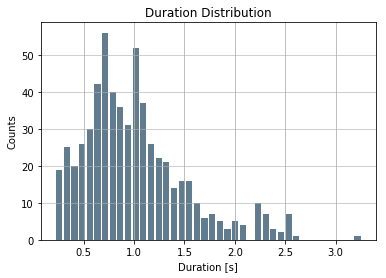

In [8]:
durationDist = pd.Series(np.array(duration))
plt.figure()
durationDist.plot.hist(grid=True, bins=40, rwidth=0.8,
                   color='#607c8e')
plt.title('Duration Distribution')
plt.xlabel('Duration [s]')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
print("Duration average:",np.mean(duration))

## Short-Time Fourier Transform

In [9]:
show_web("https://en.wikipedia.org/wiki/Short-time_Fourier_transform")

Spectogram Array Shape: (1025, 87)


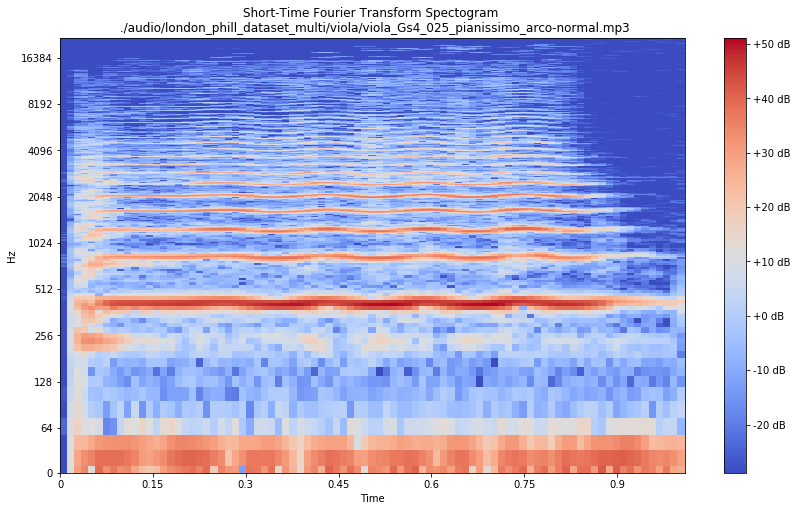

In [10]:
# STFT Example
y, sr = librosa.load(files[10], sr=fs, duration=1)
y/=y.max() #Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to 1s if smaller
y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec=librosa.amplitude_to_db(abs(y_stft), np.max)
plt.figure(figsize=(14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%files[0])
librosa.display.specshow(y_spec,sr=fs,y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB');
print("Spectogram Array Shape:",y_spec.shape)
ipd.Audio(y, rate=fs)

## Encode Labels

In [11]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels=encoder.fit_transform(classes_num.reshape(len(classes_num),1))

6 classes: cello, flute, oboe, sax, trumpet, viola


## Train and Test Sets

In [12]:
# Create Train and Test Sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files, onehot_labels)
files_arr=np.array(files)

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_classes = onehot_labels[train_index]
    test_classes = onehot_labels[test_index]

## Convolutional Neural Networks

In [13]:
show_web("https://en.wikipedia.org/wiki/Convolutional_neural_network")

## Create Model

In [14]:
# CNN Model
model = Sequential()

conv_filters =  16  # number of convolution filters

# Layer 1
model.add(Convolution2D(conv_filters, 3,input_shape=(1025, 87, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.40)) 

# Layer 2
model.add(Convolution2D(conv_filters, 3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Flatten
model.add(Flatten()) 

# Full layer
model.add(Dense(16, activation='sigmoid')) 

# Output layer
model.add(Dense(6,activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1023, 85, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 42, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 511, 42, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 509, 40, 16)       2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 20, 16)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 20, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 81280)             0         
__________

In [16]:
# Loss Function 
loss = 'categorical_crossentropy' 

# Optimizer = Gradient Descent
optimizer = 'sgd' 

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

## Train Model

In [17]:
def featureGenerator(files, labels):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                label = []
                y, sr = librosa.load(f, sr=fs, duration=1)
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                y/=y.max() #Normalize
                duration_in_samples=librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to same duration
                y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler = StandardScaler()
                dtype = K.floatx()
                data = scaler.fit_transform(y_spec).astype(dtype)
                data = np.expand_dims(data, axis=0)
                data = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                label.append([labels[i]])
                yield feature_vectors, label
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

In [18]:
%%time
hist = History();
es = EarlyStopping(monitor='val_acc', min_delta=0.01, restore_best_weights=True, patience= 10, verbose=1 )
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',save_best_only=True, verbose=1)


try:
    import google.colab
    tbc=TensorBoardColab()
    callbacksKeras=[hist,es,mc,TensorBoardColabCallback(tbc)]

except Exception as e:
    callbacksKeras=[hist,es,mc]
    print("Not inside Google Colab: %s. Using standard configurations." % (e))


model.fit_generator(featureGenerator(train_set_files, train_classes), 
                    validation_data=(featureGenerator(test_set_files, test_classes)), 
                    validation_steps=150, 
                    steps_per_epoch=450,epochs=30,callbacks=callbacksKeras, verbose=1)

Not inside Google Colab: No module named 'google.colab'
Epoch 1/30
450/450 [==============================] - 114s 254ms/step - loss: 1.1905 - acc: 0.6200 - val_loss: 0.9080 - val_acc: 0.7800

Epoch 00001: val_acc improved from -inf to 0.78000, saving model to best_model.h5
Epoch 2/30
450/450 [==============================] - 101s 224ms/step - loss: 0.6555 - acc: 0.8578 - val_loss: 0.6386 - val_acc: 0.8200

Epoch 00002: val_acc improved from 0.78000 to 0.82000, saving model to best_model.h5
Epoch 3/30
450/450 [==============================] - 94s 208ms/step - loss: 0.3602 - acc: 0.9511 - val_loss: 0.3795 - val_acc: 0.9267

Epoch 00003: val_acc improved from 0.82000 to 0.92667, saving model to best_model.h5
Epoch 4/30
450/450 [==============================] - 107s 237ms/step - loss: 0.2174 - acc: 0.9911 - val_loss: 0.2405 - val_acc: 0.9533

Epoch 00004: val_acc improved from 0.92667 to 0.95333, saving model to best_model.h5
Epoch 5/30
450/450 [==============================] - 105s 2

KeyboardInterrupt: 

In [19]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
plot_history(hist)

NameError: name 'history' is not defined

## Evaluate Model

In [ ]:
saved_model = load_model('best_model.h5')
test_pred = saved_model.predict_generator(featureGenerator(test_set_files, test_classes), steps=150,verbose=1)

In [ ]:
predictions_round=np.around(test_pred).astype('int');
predictions_int=np.argmax(predictions_round,axis=1);
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int));

In [ ]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

In [ ]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_num[test_index], predictions_int)) if e1 != e2]


In [ ]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])